# Value at Risk (VaR) and Conditional VaR (CVaR)

In this notebook we compute two popular risk measures Value at Risk (VaR), and Conditional VaR (CVaR) (also called Expected Shortfall).
Goals:

1. Compute historical VaR and CVaR from portfolio returns  
2. Compute parametric VaR and CVaR assuming
   - a Normal distribution
   - a Student-t distribution   

We assume no asset correlations and work with a single portfolio return series (univariate) in this notebook. 

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
plt.style.use("default")

We pick a few large US tech stocks, compute their daily returns from Closing prices, and then form a simple equal-weight portfolio.

In [177]:
tickers = ["AAPL", "MSFT", "GOOG"]
start_date = "2015-01-01"

data = yf.download(tickers, start=start_date,auto_adjust=True)
prices = data["Close"].dropna()  # adjusted close prices

print("Prices shape:", prices.shape)
prices.tail()

[*********************100%***********************]  3 of 3 completed

Prices shape: (2742, 3)


Ticker,AAPL,GOOG,MSFT
Date,,,
2025-11-19,268.559998,292.989990,486.209991
2025-11-20,266.250000,289.980011,478.429993
2025-11-21,271.489990,299.649994,472.119995
2025-11-24,275.920013,318.470001,474.000000
2025-11-25,276.970001,323.640015,476.989990


In [178]:
# Daily simple returns
asset_returns = prices.pct_change().dropna()

print("Asset returns shape:", asset_returns.shape)
asset_returns.head()

Asset returns shape: (2741, 3)


Ticker,AAPL,GOOG,MSFT
Date,,,
2015-01-05,-0.028172,-0.020846,-0.009196
2015-01-06,0.000094,-0.023177,-0.014677
2015-01-07,0.014022,-0.001713,0.012705
2015-01-08,0.038422,0.003153,0.029418
2015-01-09,0.001072,-0.012951,-0.008405


In [179]:
# Define simple portfolio weights (sum to 1) 
weights = np.array([1/len(tickers)] * len(tickers)) # equal weights 

# Portfolio daily returns: weighted sum across of asset returns that day.
portfolio_returns = asset_returns.dot(weights)
portfolio_returns = pd.Series(portfolio_returns, index=asset_returns.index, name="Portfolio")
print("Portfolio returns shape:", portfolio_returns.shape)

Portfolio returns shape: (2741,)


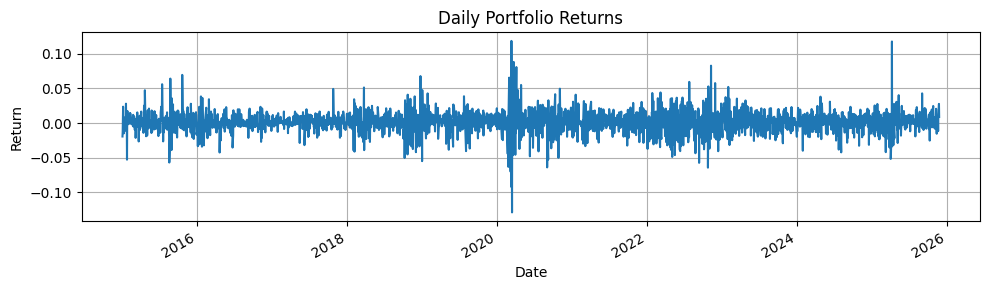

In [180]:
fig, ax = plt.subplots(figsize=(10, 3))
portfolio_returns.plot(ax=ax)
ax.set_title("Daily Portfolio Returns")
ax.set_ylabel("Return")
ax.grid(True)
plt.tight_layout()
plt.show()

From the time series we can visualise the shocks, but not the shape of the return distribution. For risk modelling, we can use a KDE plot.

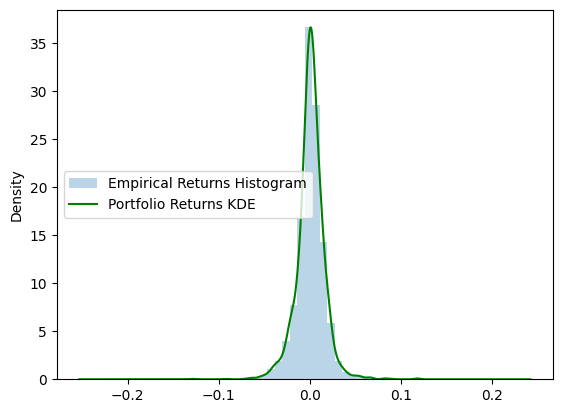

In [188]:
portfolio_returns.hist(bins=30, density=True, alpha=0.3,  label='Empirical Returns Histogram')
portfolio_returns.plot(kind='kde', color='green', label='Portfolio Returns KDE')
plt.legend()

### 2. Historical VaR and CVaR

We now compute historical VaR and CVaR directly from the empirical distribution of portfolio returns.

We define loss as the negative of return:

- if return = −3%, loss = +3%
- if return = +2%, loss = 0% (we are mainly interested in the loss tail)

For a confidence level $ \alpha $ (for example 95% or 99%):

- VaR\_$\alpha$ is the loss level such that only $ 1 - \alpha $ of observations are worse.
- CVaR\_$\alpha$ is the average loss in those worst $ 1 - \alpha $ cases (the tail beyond VaR).


In [208]:
VaR,CVaR={},{}
alpha_values = [0.95, 0.99]
for alpha in alpha_values:
    VaR[alpha] = {}
    CVaR[alpha] = {}

In [209]:
# Convert returns to losses (positive means we lose money)
losses = -portfolio_returns

for alpha in alpha_values:
    # Historical VaR: alpha-quantile of losses
    var_alpha = np.quantile(losses, alpha)

    # Historical CVaR: average loss beyond VaR
    tail_losses = losses[losses >= var_alpha]
    cvar_alpha = tail_losses.mean()

    print(f"{int(alpha*100)}% Historical VaR:  {var_alpha:.4%}")
    print(f"{int(alpha*100)}% Historical CVaR: {cvar_alpha:.4%}")
    print()
    CVaR[alpha]['historical']= cvar_alpha
    VaR[alpha]['historical']= var_alpha

95% Historical VaR:  2.4041%
95% Historical CVaR: 3.5926%

99% Historical VaR:  4.2020%
99% Historical CVaR: 5.4947%



historical VaR and CVaR is a good benchmark and sanity check, but it is too simple. We need to complement it by fitting some parametric distributions to the portfolio return series and calculating the parametric VaR and CVaR. 


Let us first fit a normal distribution to the portfolio returns data, and run some tests to see if it is a good fit.

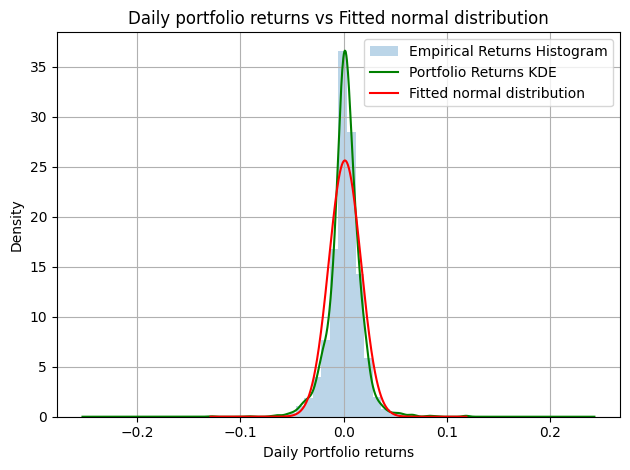

In [210]:
portfolio_returns.hist(bins=30, density=True, alpha=0.3,  label='Empirical Returns Histogram')
portfolio_returns.plot(kind='kde', color='green', label='Portfolio Returns KDE')

x=np.linspace(portfolio_returns.min(),portfolio_returns.max(),1000)
mu_hat, sigma_hat = norm.fit(portfolio_returns)
plt.plot(x,stats.norm.pdf(x, mu_hat, sigma_hat),'r-', label='Fitted normal distribution')

plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [211]:
# === 4. Normality tests: Shapiro–Wilk and KS ===

mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()

print(f"Sample mean: {mean:.6f}")
print(f"Sample std : {std_dev:.6f}")

# Shapiro-Wilk test (use a subset of 5000 points; since Shapiro is O(n^2))

returns_for_shapiro = portfolio_returns.sample(n=min(len(portfolio_returns), 5000), random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(returns_for_shapiro)

print("\nShapiro–Wilk test:")
print(f"  W-statistic: {shapiro_stat:.4f}")
print(f"  p-value    : {shapiro_p:.4g}")

# KS test vs fitted normal distribution
ks_stat, ks_p = stats.kstest(portfolio_returns, "norm")

print("\nKolmogorov–Smirnov test vs fitted Normal:")
print(f"  KS-statistic: {ks_stat:.4f}")
print(f"  p-value     : {ks_p:.4g}")


Sample mean: 0.001064
Sample std : 0.015571

Shapiro–Wilk test:
  W-statistic: 0.9319
  p-value    : 1.166e-33

Kolmogorov–Smirnov test vs fitted Normal:
  KS-statistic: 0.4756
  p-value     : 0


The p values are 0 in both cases, implying that the normal distribution is a bad fit in this case. lets nonetheless calculate the parametric VaR and CVaR for this case

In [214]:
for alpha in alpha_values:
   
    mu_L    = losses.mean()         # mean loss
    sigma_L = losses.std()   

    z = stats.norm.ppf(alpha)       # right-tail quantile for losses

    var_loss  = mu_L + sigma_L * z # equivalent to - (mu - sigma*z)
    cvar_loss = mu_L + sigma_L * stats.norm.pdf(z) / (1 - alpha) # E[Loss | Loss >= VaR], mean of right truncated normal

    print(f"{int(alpha*100)}% Normal VaR:  {var_loss:.4%}")
    print(f"{int(alpha*100)}% Normal CVaR: {cvar_loss:.4%}")
    VaR[alpha]['param_normal'] = var_loss
    CVaR[alpha]['param_normal'] = cvar_loss
    print()

95% Normal VaR:  2.4548%
95% Normal CVaR: 3.1054%

99% Normal VaR:  3.5159%
99% Normal CVaR: 4.0436%



 Lets use a QQ plot to visualise this drawback of this fit.

<Figure size 600x600 with 0 Axes>

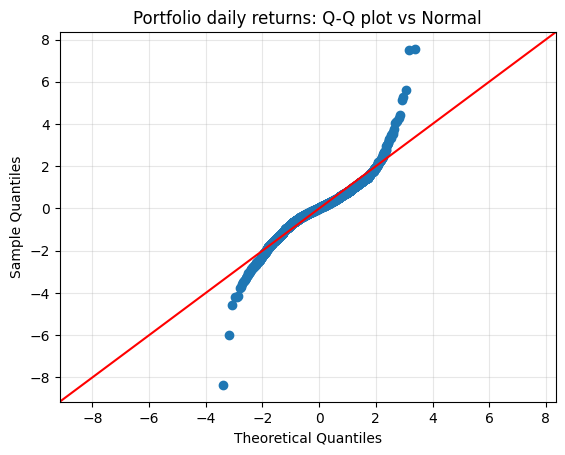

In [215]:
# ===  Q-Q plot vs normal ===

plt.figure(figsize=(6, 6))
sm.qqplot(portfolio_returns,dist=stats.norm,fit =True, line="45")  # 's' = standardized line

plt.title(f"Portfolio daily returns: Q-Q plot vs Normal")
plt.grid(True, alpha=0.3)
plt.show()

The fit struggles especially in the tails, suggesting that a Student's t-distribution might be a better choice. 

In [216]:
# Fit Student-t to portfolio returns
df_hat, loc_hat, scale_hat = stats.t.fit(portfolio_returns)

print("Fitted Student-t parameters:")
print("df   =", df_hat)
print("loc  =", loc_hat)
print("scale=", scale_hat)

Fitted Student-t parameters:
df   = 3.1185985175659123
loc  = 0.0014502206707164259
scale= 0.010029646158115833


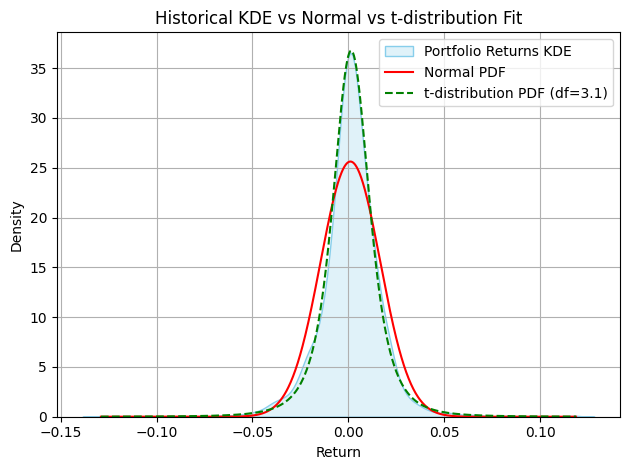

In [217]:
# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, stats.norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, stats.t.pdf(x, df=df_hat, loc=loc_hat, scale=scale_hat), 'g--', label=f't-distribution PDF (df={df_hat:.1f})')


plt.title("Historical KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [218]:
# === 4. KS ===

# KS test vs fitted Student's t distribution
ks_stat, ks_p = stats.kstest(portfolio_returns, "t", args=(df_hat, loc_hat, scale_hat))

print("\nKolmogorov–Smirnov test vs fitted t:")
print(f"  KS-statistic: {ks_stat:.4f}")
print(f"  p-value     : {ks_p:.4g}")



Kolmogorov–Smirnov test vs fitted t:
  KS-statistic: 0.0209
  p-value     : 0.1798


In [219]:

# Compute log-likelihoods
loglik_t = np.sum(stats.t.logpdf(portfolio_returns, df_hat, loc_hat, scale_hat)) 
loglik_n = np.sum(stats.norm.logpdf(portfolio_returns, mu_hat, sigma_hat))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")

AIC (t): -15578.11
AIC (normal): -15036.47


Given the data, the t distribution provides a better trade-off between fit and complexity (has lower AIC) than the normal, so it should be preferred for modelling returns. This makes sense since financial returns often have heavier tails.

<Figure size 600x600 with 0 Axes>

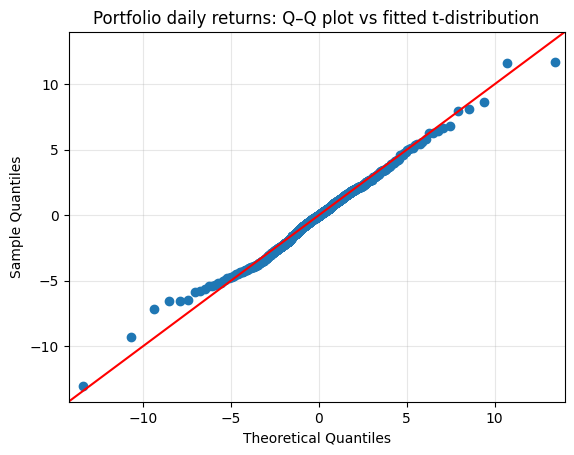

In [221]:
# 2. Q–Q plot vs fitted t
plt.figure(figsize=(6, 6))
sm.qqplot(
    portfolio_returns,
    dist=stats.t,           # use Student-t instead of normal
    fit=True,
    line="45"               # 45° reference line
)
plt.title("Portfolio daily returns: Q–Q plot vs fitted t-distribution")
plt.grid(True, alpha=0.3)
plt.show()

Here we assume losses follow a t distribution and use its fitted parameters, we can calculate the VaR and CVaR. As closed-form CVaR for t is a bit messy, we compute it numerically using Monte Carlo simulations.

In [ ]:

n_sim = 100_000  # number of Monte Carlo samples for the t model

for alpha in alpha_values:
    
    # Parametric VaR for returns: t-quantile
    var_return_t = stats.t.ppf(1 - alpha, df=df_hat, loc=loc_hat, scale=scale_hat)
    var_loss_t = -var_return_t

    # Parametric CVaR approximation using Monte Carlo samples
    simulated_returns_t = stats.t.rvs(df_hat, loc_hat, scale_hat, size=n_sim)
    simulated_losses_t = -simulated_returns_t

    var_sim = np.quantile(simulated_losses_t, alpha)
    tail_sim = simulated_losses_t[simulated_losses_t >= var_sim]
    cvar_loss_t = tail_sim.mean()

    print(f"{int(alpha*100)}% Student-t VaR :  {var_loss_t:.4%}")
    print(f"{int(alpha*100)}% Student-t CVaR (MC approx.): {cvar_loss_t:.4%}")
    print()
    VaR[alpha]['param_t'] = var_loss_t
    CVaR[alpha]['param_t'] = cvar_loss_t

95% Student-t VaR (theoretical):  2.1792%
95% Student-t CVaR (MC approx.): 3.6122%

99% Student-t VaR (theoretical):  4.2735%
99% Student-t CVaR (MC approx.): 6.5453%



In [223]:
VaR, CVaR

({0.95: {'historical': np.float64(0.02404108215330769),
   'param_normal': np.float64(0.024547949043258962),
   'param_t': np.float64(0.021791698507267303)},
  0.99: {'historical': np.float64(0.04202032496035086),
   'param_normal': np.float64(0.03515926347519784),
   'param_t': np.float64(0.04273520461701857)}},
 {0.95: {'historical': np.float64(0.035925754498254185),
   'param_normal': np.float64(0.03105429179242981),
   'param_t': np.float64(0.03612234988110599)},
  0.99: {'historical': np.float64(0.05494663374188396),
   'param_normal': np.float64(0.04043563575038849),
   'param_t': np.float64(0.06545297879831379)}})

### Comparison: historical vs normal vs Student-t (univariate)

For a quick comparison, we can collect the VaR / CVaR estimates at 95% and
99% into a small table.


,historical,param_normal,param_t
0.950000,2.4041%,2.4548%,2.1792%
0.990000,4.2020%,3.5159%,4.2735%


,historical,param_normal,param_t
0.950000,3.5926%,3.1054%,3.6122%
0.990000,5.4947%,4.0436%,6.5453%


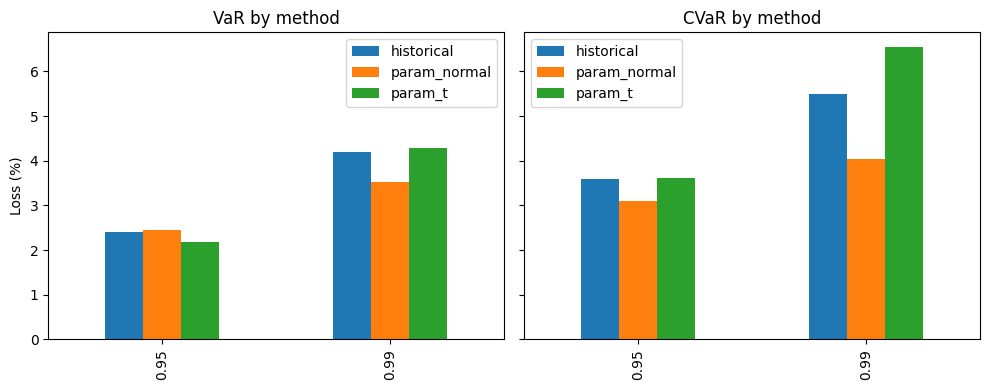

In [228]:
# Turn into DataFrames (rows = level, cols = method)
df_var  = pd.DataFrame(VaR).T      # VaR
df_cvar = pd.DataFrame(CVaR).T     # CVaR

display(df_var.style.format("{:.4%}"))
display(df_cvar.style.format("{:.4%}"))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

(df_var * 100).plot(kind="bar", ax=axes[0])
axes[0].set_title("VaR by method")
axes[0].set_ylabel("Loss (%)")
axes[0].legend()

(df_cvar * 100).plot(kind="bar", ax=axes[1])
axes[1].set_title("CVaR by method")
axes[1].legend()

plt.tight_layout()
plt.show()


At the 95 percent level the normal model looks acceptable. Its VaR is close to the historical VaR and its CVaR is only mildly optimistic. For moderately bad days a Gaussian approximation is not completely misleading.At 99 percent howver, the normal model clearly underestimates risk. The t on the otherhand captures fat tails better and is more conservative for extreme losses.